In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

In [3]:
#create city class
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [20]:
#create fitness class
#fitness is the inverse of route distance
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    def routeDistance(self):
        if self.distance == 0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i+1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

In [21]:
#create initial population
#only needed for initial population, each subsequent generation will be produced through breeding and mutation
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route
def initialPopulation(popSize, cityList):
    population = []
    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

In [22]:
#simulate survival of the fittest
#output will be ordered list with route IDs and associated fitness score
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0, len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [33]:
#use fitness proportionae selection to select mating pool
def selection(popRanked, eliteSize):
    selectionResults = []
    
    #set up roulette wheel by calculating a relative fitness weight for each individual
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    #introduce elitism (hold onto best weights)
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
        
    #compare randomly drawn number to weights to select pool
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0 , len(popRanked)):
            if pick <= df.iat[i, 3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

In [34]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [35]:
#create next generation through breeding aka crossover
#ordered crossover bc TSP
#randomly select subset of first parent string and then fill in remainder with genes from second parent
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

In [36]:
#generalize to create offspring population
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [37]:
#mutation to avoid local convergence
#use swap mutation: low prop of two cities swapping places in route
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

In [38]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [39]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [40]:
#tester that captures initial and final distance to measure efficiency
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

In [41]:
#testing
cityList = []
for i in range(0,25):
    cityList.append(City(x=int(random.random()*200), y=int(random.random() * 200)))

In [44]:
#plot improvement
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

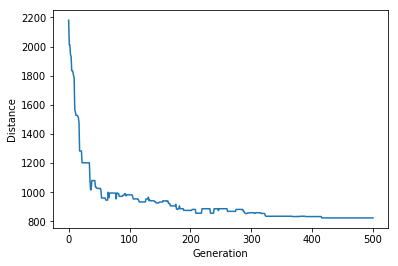

In [45]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)